![ga4](https://www.google-analytics.com/collect?v=2&tid=G-6VDTYWLKX6&cid=1&en=page_view&sid=1&dl=statmike%2Fvertex-ai-mlops%2FApplied+GenAI&dt=Vertex+AI+GenAI+For+Document+Q%26A+-+NFL+Rules+For+Football.ipynb)

# Document Q&A: NFL Rules For Football

**What?**

Ask questions of the rules for football (American) from the NFL and get answers with specific references to official rules.

**Sources:**

The official NFL rules are at [this link](https://operations.nfl.com/the-rules/2022-nfl-rulebook/).  This is a 245 page PDF document.

**Tools:**
- Vertex AI LLM Embedding API
  - `vertexai.preview.language_models.TextEmbeddingModel.from_pretrained('embedding-gecko@001')`
- Vertex AI GenAI Language Model API
  - `vertexai.preview.language_models.TextGenerationModel.from_pretrained('text@bison-001')`
- Input file processing into documents/elements with GCP Document AI
  - `google.cloud.documentai.DocumentProcessorServiceClient()`
- Embedding search: with [ScaNN](https://github.com/google-research/google-research/tree/master/scann), [chromadb](https://github.com/chroma-core/chroma), [Vertex AI Matching Engine](https://cloud.google.com/vertex-ai/docs/matching-engine/overview)
  - this example uses `ScaNN` in the notebook

---

**Google Cloud Vertex AI Generative AI Support**

Vertex AI Generative AI gives access to Google's large genearative AI models and also enables you to test, tune, and deploy them for your applications. Get an overview [here](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/overview).

---

**How:**

- Create documents from the source information.
  - <u>Definition</u>: a document is a section of the rules
- Create embeddings for each document
- Ask a question
  - Create an embedding of the question
  - Use vector similarity to retrieve embeddings for related documents
  - Retrieve the documents associated with returned embeddings
  - Prepare a prompt to answer the question using the documents as context
- Present the response as an answer with links to the related documents (sections of the document).

**What is Unique?**

An LLM is likely unexposed to a users private content.  This appoach constructs a summarization prompt for an LLM by first retriving context for the question from the users documents using embeddings.  This also allows the response to be accompanied by direct reference to the users documentation used in the prompt.

**Notes**

- An LLM is likely trained on many sources that probably include lots of general knowledge, even information like what is used here.  It is also likely knowledgable of past outdated information which can be a benefit - or detriment - to accuracy.  This approach directly uses the version of the document that currently applies.

**References**

- [Vertex AI GenAI Studio](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/overview)
    - Vertex AI [Python Client](https://cloud.google.com/python/docs/reference/aiplatform/latest)
- [Document AI](https://cloud.google.com/document-ai/docs/overview)
    - Document AI [Parsers](https://cloud.google.com/document-ai/docs/processors-list)
    - Document AI [Python Client](https://cloud.google.com/python/docs/reference/documentai/latest)

---
## Overview

<p><center>
    <img alt="Overview Chart" src="../architectures/notebooks/applied/genai/doc_qa.png" width="55%">
</center><p>


---
## Colab Setup

To run this notebook in Colab click [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20GenAI/Vertex%20AI%20GenAI%20For%20Document%20Q&A%20-%20USGA%20Rules%20For%20Golf.ipynb) and run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

---
## Installs

In [ ]:
# Vertex AI GenAI Studio SDK - Update the aiplatform SDK
!pip install google.cloud.aiplatform -U -q --user

# for working with embeddings locally
!pip install scann -q --user

# For GCP DocAI and presentation of results
!pip install google-cloud-documentai -q --user
!pip install PyPDF2 -U -q --user
!pip install Pillow -U -q --user

In [47]:
# Enable Document AI For This Project
!gcloud services enable documentai.googleapis.com
# Enable Vertex AI For This Project
!gcloud services enable aiplatform.googleapis.com

The `aiplatform` version needs to be 1.25.0 or higher for the LLM functionality:

In [3]:
import google.cloud.aiplatform as aiplatform
aiplatform.__version__

'1.25.0'

**RESTART RUNTIME**

In [1]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

---
## Setup

Inputs

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [36]:
REGION = 'us-central1'
EXPERIMENT = 'nfl-rules'
SERIES = 'applied-genai'

# save results in: GCS, BQ, ALL
SAVE_IN = 'GCS'
# retrieve results from: GCS, BQ.  If not present then it will run parsing and embedding.
RETRIEVE_FROM = 'GCS'

# make this the gcs bucket for storing files
GCS_BUCKET = PROJECT_ID 

# make this the BQ Project / Dataset / Table prefix to store results
BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-', '_')
BQ_TABLE = EXPERIMENT

# location for the source document (PDF): can be http or gs://
source_document = 'https://operations.nfl.com/media/5kvgzyss/2022-nfl-rulebook-final.pdf'
#source_document = f'gs://{GCS_BUCKET}/{SERIES}/{EXPERIMENT}/2022-nfl-rulebook-final.pdf'

# first question to ask
question = "What are the rules for football?"

Packages

In [3]:
import os
import io
import json
import base64
import requests
import concurrent.futures
import time

import PyPDF2
import IPython
import PIL
import PIL.ImageFont, PIL.Image, PIL.ImageDraw
import shapely

import scann
import numpy as np

import vertexai.preview.language_models
from google.cloud import aiplatform
from google.cloud import documentai
from google.cloud.documentai_v1 import Document
from google.cloud import storage
from google.cloud import bigquery

2023-05-16 11:14:00.984290: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 11:14:06.157314: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-16 11:14:06.157610: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

Clients

In [4]:
# vertex ai clients
vertexai.init(project = PROJECT_ID, location = REGION)
aiplatform.init(project = PROJECT_ID, location = REGION)

# document AI client
LOCATION = REGION.split('-')[0]
docai_client = documentai.DocumentProcessorServiceClient(
    client_options = dict(api_endpoint = f"{LOCATION}-documentai.googleapis.com")
)

# bigquery client
bq = bigquery.Client(project = PROJECT_ID)

# gcs client: assumes bucket already exists
gcs = storage.Client(project = PROJECT_ID)
bucket = gcs.bucket(GCS_BUCKET)

---
## Vertex LLM Setup

- TextEmbeddingModel [Guide](https://cloud.google.com/vertex-ai/docs/generative-ai/embeddings/get-text-embeddings)
    - TextEmbeddingModel [API](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.preview.language_models.TextEmbeddingModel)
- TextGenerationModel [Guide](https://cloud.google.com/vertex-ai/docs/generative-ai/text/test-text-prompts)
    - TextGenerationModel [API](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.preview.language_models.TextGenerationModel)

In [5]:
# create links to model: embedding api and text generation
embedding_model = vertexai.preview.language_models.TextEmbeddingModel.from_pretrained('textembedding-gecko@001')
textgen_model = vertexai.preview.language_models.TextGenerationModel.from_pretrained('text-bison@001')

Test embedding model:

In [6]:
embedding_model.get_embeddings([question])[0].values[0:5]

[0.03846105560660362,
 -0.01430503185838461,
 0.0019403414335101843,
 0.020727993920445442,
 -0.0015102785546332598]

Test test generation (llm) model:

In [7]:
textgen_model.predict(question)

Golf is a game played on a course consisting of 18 holes. The object of the game is to hit a small ball into a hole using a club. The player with the lowest score at the end of the round wins.

The rules of golf are complex and can vary depending on the course. However, some of the most important rules include:

* Each hole has a par, which is the number of strokes that a good player is expected to take to complete the hole.
* Players must take their stance behind the ball and hit it with a club. They cannot move the ball or the ball marker once

---
## Get/Create Document AI Processors

Using the [General Form Processor](https://cloud.google.com/document-ai/docs/processors-list#general_processors) and [Document Splitter](https://cloud.google.com/document-ai/docs/processors-list#processor_doc-splitter).



In [8]:
PARSER_DISPLAY_NAME = 'my_general_processor'
PARSER_TYPE = 'FORM_PARSER_PROCESSOR'
PARSER_VERSION = 'pretrained-form-parser-v2.0-2022-11-10'

for p in docai_client.list_processors(parent = f'projects/{PROJECT_ID}/locations/{LOCATION}'):
  if p.display_name == PARSER_DISPLAY_NAME:
    parser = p
    print('Retrieved Existing Parser')
if 'parser' not in locals():
  parser = docai_client.create_processor(
      parent = f'projects/{PROJECT_ID}/locations/{LOCATION}',
      processor = dict(display_name = PARSER_DISPLAY_NAME, type_ = PARSER_TYPE, default_processor_version = PARSER_VERSION)
  )
  print('Created New Parser')

parser

Retrieved Existing Parser


name: "projects/1026793852137/locations/us/processors/99dc9d70b803f826"
type_: "FORM_PARSER_PROCESSOR"
display_name: "my_general_processor"
state: ENABLED
process_endpoint: "https://us-documentai.googleapis.com/v1/projects/1026793852137/locations/us/processors/99dc9d70b803f826:process"
create_time {
  seconds: 1683799767
  nanos: 293339000
}
default_processor_version: "projects/1026793852137/locations/us/processors/99dc9d70b803f826/processorVersions/pretrained-form-parser-v1.0-2020-09-23"

---
## Get The Document

Get the source PDF from GCS or a URL and store as a list of pages: `pdfs`.

Get Location of File

In [9]:
if source_document.startswith('http'):
    document_location = 'URL'
    print('Use requests to get online document')
elif source_document.startswith('gs'):
    document_location = 'GCS'
    print('Use GCS to get document in GCS')
else:
    document_location = 'UNKNOWN'
    print(f'The source_document variable points to a document in an unknown location type (not gs:// or http): {source_document}')

Use requests to get online document


Copy the PDF to memory:

In [10]:
if document_location == 'URL':
    response = requests.get(source_document).content
elif document_location == 'GCS':
    blob = bucket.blob(source_document.split(f'gs://{GCS_BUCKET}/')[1])
    response = blob.download_as_bytes()

In [11]:
type(response)

bytes

Split the PDF into a document per page:

In [12]:
pdf = PyPDF2.PdfReader(io.BytesIO(response))

In [13]:
len(pdf.pages)

245

In [14]:
pdfs = []
for page_num, page in enumerate(pdf.pages, 1):
  writer = PyPDF2.PdfWriter()
  writer.add_page(page)
  with io.BytesIO() as bytes_stream:
    pdfs.append(writer.write(bytes_stream)[1].getbuffer().tobytes())

---
## Retrieve Files From Previous Run on GCS Or BigQuery

This uses the input parameter set above: `RETRIEVE_FROM`.  If it is set to `BQ` or `GCS` then it will check the source for an available prior run and retrieve it if it exists.


Function to check for existance of BigQuery Table:

In [15]:
def bq_table_check(table):
    from google.cloud.exceptions import NotFound
    try:
        bq.get_table(table)
        return True
    except NotFound:
        return False
    
bq_table_check(f'{BQ_DATASET}.{BQ_TABLE}_documents')

False

In [16]:
if RETRIEVE_FROM == 'GCS' and len(list(bucket.list_blobs(prefix = f'{SERIES}/{EXPERIMENT}/results.json'))) > 0:
    print('Copying previous run from GCS')
    
    # load results: the raw data from docai parsing
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/results.json')
    results = [json.loads(line) for line in blob.download_as_text().splitlines()]
    
    # load documents: the prepared results from the docai parsing results
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/documents.json')
    documents = [json.loads(line) for line in blob.download_as_text().splitlines()]
    
    # load page images for presentation: stored in the results
    page_images = []
    for r, result in enumerate(results):
        document_image = PIL.Image.open(
            io.BytesIO(
                 # stored as string, use .encode() to convert to bytes, use base64.decodebytes to decode
                base64.decodebytes(result['pages'][0]['image']['content'].encode('utf-8'))
            )
        )
        page_images.append(document_image)    
    
    # Set Indicator to prevent redoing the parsing later in this notebook
    PRIOR_PARSE = True
elif RETRIEVE_FROM == 'BQ' and bq_table_check(f'{BQ_DATASET}.{BQ_TABLE}_documents'):
    print('Copying previous run from BigQuery')
    
    # load results: the raw data from docai parsing
    results = bq.query(f'SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_results` ORDER BY metadata.row').to_dataframe().to_dict('records')
    
    # load documents: the perpared results from the docai parsing results
    documents = bq.query(f'SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_documents` ORDER BY metadata.row').to_dataframe().to_dict('records')
    
    # load page images for presentation: stored in the results
    page_images = []
    for r, result in enumerate(results):
        document_image = PIL.Image.open(
            io.BytesIO(
                 # stored as base64 encoded bytes in BQ and retrieved in that format
                result['pages'][0]['image']['content']
            )
        )
        page_images.append(document_image) 
    
    # Set Indicator to prevent redoing the parsing later in this notebook
    PRIOR_PARSE = True
else:
    print('No previous run available to copy over')
    PRIOR_PARSE = False

No previous run available to copy over


---
## Parse Documents

Results of:
- [google.cloud.documentai.DocumentProcessorServiceClient().process_document()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.services.document_processor_service.DocumentProcessorServiceClient#google_cloud_documentai_v1_services_document_processor_service_DocumentProcessorServiceClient_process_document)
  - are in the format of
    - [google.cloud.documentai_v1.types.ProcessResponse()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessResponse)
      - which contains `.document` in the format of:
        - [google.cloud.documentai_v1.types.Document](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document)

Converting the Document to:
- JSON with .to_json()
- dictionary with .to_dict()

**Document AI Notes:**
- In this application we are using online processing.  This has a limit of 15 pages per document.  Switch to batch increases this to 100 pages for the Form Parser (General).
- Online processing has a default qouta of 120 request per minute per project. The code below implement waiting time to avoid this limit.
- [Reference](https://cloud.google.com/document-ai/quotas)

In [17]:
rate_limit_minute = 120
adjust_rate_limit = rate_limit_minute / 2

In [18]:
def docai_runner(p, start, raw_document):
  sleep_time = (p * (60/adjust_rate_limit)) - (time.time() - start)
  if sleep_time > 0: time.sleep(sleep_time)

  return (p, docai_client.process_document(request = dict(raw_document = raw_document, name = parser.name)))

In [19]:
if PRIOR_PARSE:
    print('Using Prior Results')
else:
    print('No Prior Results, Parsing with Document AI')
    print(f"The Expected runtime for the parsing is {(len(pdfs)/adjust_rate_limit):.2f} minutes")
    results = [None] * len(pdfs)
    start = time.time()
    with concurrent.futures.ThreadPoolExecutor(max_workers = len(pdfs)) as executor:
        futures = [
            executor.submit(
                docai_runner,
                p, start,
                documentai.RawDocument(content = pdf, mime_type = 'application/pdf')
            ) for p, pdf in enumerate(pdfs)
        ]
        for future in concurrent.futures.as_completed(futures):
          #result = futures[future]
          results[future.result()[0]] = (Document.to_dict(future.result()[1].document))

No Prior Results, Parsing with Document AI
The Expected runtime for the parsing is 4.08 minutes


In [20]:
len(pdfs), len(results)

(245, 245)

In [21]:
if PRIOR_PARSE:
  print('Using Prior Documents Preparation')
else:
  documents = []
  page_images = []
  for r, result in enumerate(results):
    
    # add order to results:
    results[r]['metadata'] = dict(row = r)
    
    document_image = PIL.Image.open(
        io.BytesIO(
            base64.decodebytes(result['pages'][0]['image']['content'].encode('utf-8'))
            )
        )
    page_images.append(document_image)

    tables = []
    for t, table in enumerate(result['pages'][0]['tables']):
      table_txt = ''
      if 'text_anchor' in table['layout'].keys():
        for s, segment in enumerate(table['layout']['text_anchor']['text_segments']):
          if t == 0 and s == 0: start = 0
          else: start = int(segment['start_index'])
          end = int(segment['end_index'])
          table_txt += result['text'][start:end+t]

      vertices = []
      for vertex in table['layout']['bounding_poly']['normalized_vertices']:
        vertices.append(dict(x = vertex['x'] * document_image.size[0], y = vertex['y'] * document_image.size[1]))
      tables.append(shapely.geometry.Polygon([(v['x'], v['y']) for v in vertices]))

      documents.append(
          dict(
              page_content = table_txt,
              metadata = dict(
                  page = r+1,
                  table = t+1,
                  row = len(documents),
                  filename = source_document.split('/')[-1],
                  source_document = source_document
              ),
              extras = dict(
                  #image = base64.decodebytes(result['pages'][0]['image']['content'].encode('utf-8')),
                  vertices = vertices
              )
          )
      )

    for p, paragraph in enumerate(result['pages'][0]['paragraphs']):

      paragraph_txt = ''
      for s, segment in enumerate(paragraph['layout']['text_anchor']['text_segments']):
        if p == 0 and s == 0: start = 0
        else: start = int(segment['start_index'])
        end = int(segment['end_index'])
        paragraph_txt += result['text'][start:end+1]

      vertices = []
      for vertex in paragraph['layout']['bounding_poly']['normalized_vertices']:
        vertices.append(dict(x = vertex['x'] * document_image.size[0], y = vertex['y'] * document_image.size[1]))

      # only use paragraph that are not within table boundaries
      use_paragraph = True
      for t_shape in tables:
        p_shape = shapely.geometry.Polygon([(v['x'], v['y']) for v in vertices])
        if p_shape.intersects(t_shape): use_paragraph = False

      if use_paragraph:
        documents.append(
            dict(
                page_content = paragraph_txt,
                metadata = dict(
                    page = r+1,
                    paragraph = p+1,
                    row = len(documents),
                    filename = source_document.split('/')[-1],
                    source_document = source_document
                ),
                extras = dict(
                    #image = base64.decodebytes(result['pages'][0]['image']['content'].encode('utf-8')),
                    vertices = vertices
                )
            )
        )

len(documents)

1339

In [22]:
print(documents[300]['page_content'])

46



In [23]:
print(documents[300]['metadata'])

{'page': 54, 'paragraph': 2, 'row': 300, 'filename': '2022-nfl-rulebook-final.pdf', 'source_document': 'https://operations.nfl.com/media/5kvgzyss/2022-nfl-rulebook-final.pdf'}


---
## Get Embeddings


In [24]:
rate_limit_minute = 150

In [25]:
if PRIOR_PARSE:
  print('Embeddings created on previous run.')
else:
  print(f"The expected run time for embeddings is {(len(documents)/rate_limit_minute):.2f} minutes")
  start = time.time()
  for d, document in enumerate(documents):
    if d % rate_limit_minute == 0:
      time.sleep(((time.time() - start) % 60) + 10)
      start = time.time()
    text = document['page_content']
    if text:
      embed = embedding_model.get_embeddings([text])[0].values
    else:
      embed = []
    documents[d]['embedding'] = embed

The expected run time for embeddings is 8.93 minutes


## Create Embeddings Database


Use [ScaNN](https://github.com/google-research/google-research/tree/master/scann) to build a local vector search capability.

In [26]:
index = np.empty((len(documents), len(documents[0]['embedding'])))
index.shape

(1339, 768)

In [27]:
type(results) == list

True

In [28]:
if type(documents[0]['embedding']) == list:
    for i in range(index.shape[0]):
        if documents[i]['page_content']:
            index[i] = documents[i]['embedding']        
elif type(documents[0]['embedding']) == np.ndarray: # retrieved from BigQuery
    for i in range(index.shape[0]):
        if documents[i]['page_content']:
            index[i] = documents[i]['embedding'].tolist()        

In [29]:
normalized_index = index / np.linalg.norm(index, axis=1)[:, np.newaxis]

In [30]:
# configure ScaNN as a tree - asymmetric hash hybrid with reordering
# anisotropic quantization as described in the paper; see README

# use scann.scann_ops.build() to instead create a TensorFlow-compatible searcher
builder = scann.scann_ops_pybind.builder(
    normalized_index, # index
    10, # num_neighbors
    "dot_product" # distance_measure
    )

searcher = builder.tree(
    num_leaves=index.shape[0], #num_leaves
    num_leaves_to_search=index.shape[0], #num_leaves_to_search
    training_sample_size=index.shape[0]
    ).score_ah(
      2,
      anisotropic_quantization_threshold=0.2
      ).reorder(
          index.shape[0]
          ).build()

In [31]:
def search_index(query, k):
    query = embedding_model.get_embeddings([query])[0].values
    neighbors, distances = searcher.search(query, final_num_neighbors=k)
    return list(zip(neighbors, distances))

In [32]:
search_index(question, 4)

[(1, 0.6995561), (166, 0.6782423), (130, 0.6697298), (175, 0.6635471)]

---
## Save For Future Runs: GCS, BigQuery

Use the values of the input parameter `SAVE_IN` to optionally write both `results` and `documents` to `BQ`, `GCS` or `ALL` (both).

It can take awhile to run the parsing job above so save results for future runs of this notebook.  Also, this prevents recurring cost of running the Document AI parsing of the documents.

In [33]:
if PRIOR_PARSE:
    print('This run loaded results from a prior run.  Not overwriting.')
else:
    if SAVE_IN in ['GCS', 'ALL']:
        print('Writing contents of results and documents to GCS for future use.')

        # save results: json lines
        blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/results.json')
        blob.upload_from_string('\n'.join([json.dumps(result) for result in results]), content_type = 'application/json')

        # save documents: json lines
        blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/documents.json')
        blob.upload_from_string('\n'.join([json.dumps(document) for document in documents]), content_type = 'application/json')
    if SAVE_IN in ['BQ', 'ALL']:
        print('Writing contents of results and documents to BigQuery for future use.')

        # create/link to dataset
        ds = bigquery.DatasetReference(BQ_PROJECT, BQ_DATASET)
        ds.location = REGION
        ds.labels = {'series': f'{SERIES}', 'experiment': f'{EXPERIMENT}'}
        ds = bq.create_dataset(dataset = ds, exists_ok = True)    

        # make load job configuration
        job_config = bigquery.LoadJobConfig(
            source_format = bigquery.SourceFormat.NEWLINE_DELIMITED_JSON,
            write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE, #.WRITE_APPEND, #.WRITE_TRUNCATE,
            create_disposition = bigquery.CreateDisposition.CREATE_IF_NEEDED,
            autodetect = True
        )    

        # save results
        load_job = bq.load_table_from_json(
            json_rows = results,
            destination = ds.table(BQ_TABLE + '_results'),
            job_config = job_config
        )
        load_job.result()   

        # save documents
        load_job = bq.load_table_from_json(
            json_rows = documents,
            destination = ds.table(BQ_TABLE + '_documents'),
            job_config = job_config
        )
        load_job.result()       

Writing contents of results and documents to GCS for future use.


**Note on Schema Changes**

When writing `results` to BigQuery the value of `results[*]['pages'][0]['image']['content']` is automatically converted to base64 encoding and is in `bytes` format.  When retrieve back to a Python variable this does not convert back to `string`.  This would results in needing to modify one line of the import parsing:

```Python
#FROM
base64.decodebytes(result['pages'][0]['image']['content'].encode('utf-8'))
#TO
result['pages'][0]['image']['content']
```

### Save Embeddings For Vertex AI Matching Engine

The notebook [Vertex AI Matching Engine For Document Q&A](./Vertex%20AI%20Matching%20Engine%20For%20Document%20Q&A.ipynb) shows how to host the embeddings on [Vertex AI Matching Engine](https://cloud.google.com/vertex-ai/docs/matching-engine/overview) for stateful, low-latency vector searching.  The code below saves the embeddings in JSON, one of the [supported input formats](https://cloud.google.com/vertex-ai/docs/matching-engine/match-eng-setup/format-structure#data-file-formats) for Vertex AI Matching Engine index creation.


In [34]:
if SAVE_IN in ['GCS', 'ALL']:
    print('Writing embeddings to GCS for Use in Vertex AI Matching Engine.')
    # save results: json lines
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/vertex_matching/embeddings.json')
    blob.upload_from_string('\n'.join([json.dumps(dict(id = document['metadata']['row'], embedding = document['embedding'])) for document in documents]), content_type = 'application/json')

Writing embeddings to GCS for Use in Vertex AI Matching Engine.


---
## Q&A With DocumentBot

Make a function that receives the users questions and:
- finds and retrieves relative sections of the rules
- prepares a prompt for Vertex AI Generative AI that includes the question and the context = sections of document
- Retrieves the response (answer) from Vertex AI Generative AI
- Retrieves the closest match section of the rules to the response/answer.
- Checks to see if the section closest to the response/answer was included in the sections of the rules provided in the prompt.
- Prepares and presents all the information back to the user

In [35]:
def document_bot(question):

    # Get the score for the closest match
    score = search_index(question, k = 1)[0][1]
    
    # retrieve related documents - the nubmer is based on the distance score from the closest match
    relevant_documentation = search_index(question, k = 1 + 2*int(10*(1-score)))

    # prepare context for prompt
    context = "\n".join([f'Context {c+1}:\n' + documents[doc[0]]['page_content'] for c, doc in enumerate(relevant_documentation)])
    
    # construct the prompt
    prompt = f"""
        Give a detailed answer to the question using information from the provided contexts.

        {context}

        Question:
        {question}

        Answer and Explanation:
    """

    #print(prompt)

    # retrieve response
    response = textgen_model.predict(prompt)
    
    # get closest document to the response:
    likely_source = search_index(response, k=1)[0]
    
    # declare likely source: if closest document to response was in context pick it, otherwise pick first context match
    if likely_source[0] in [rd[0] for rd in relevant_documentation]:
        likely = True
        likely_document = documents[likely_source[0]]
    else:
        likely = False
        likely_document = documents[relevant_documentation[0][0]]


    sources = "\n".join(f"* {documents[doc[0]]['metadata']['source_document']}#page={documents[doc[0]]['metadata']['page']}\n\t* Document: {documents[doc[0]]['metadata']['filename']}, page: {documents[doc[0]]['metadata']['page']}, relevance to question: {doc[1]:.2f}" for doc in relevant_documentation)
    answer = f"""## Response
### Question
{question}
### Answer
{response}
### Why?
{likely_document['page_content']}
* page: {likely_document['metadata']['page']}, relevance to answer: {likely_source[1]:.2f}
* {likely_document['metadata']['source_document']}#page={likely_document['metadata']['page']}
### Sources
{sources}        
    """
    IPython.display.display(IPython.display.Markdown(answer))
        
    #font = PIL.ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf", 20)
    document_image = page_images[likely_document['metadata']['page']-1]
    vertices = documents[likely_document['metadata']['row']]['extras']['vertices']
    draw = PIL.ImageDraw.Draw(document_image).polygon([
        vertices[0]['x'], vertices[0]['y'],
        vertices[1]['x'], vertices[1]['y'],
        vertices[2]['x'], vertices[2]['y'],
        vertices[3]['x'], vertices[3]['y']
    ], outline = 'green', width = 5)
    IPython.display.display(document_image.resize((800, 1000)))

    return

In [37]:
question

'What are the rules for football?'

## Response
### Question
What are the rules for football?
### Answer
The rules of football are defined in the official rule book of the National Football League (NFL). The rules are designed to ensure the safety of players and to promote fair play. The rules cover a wide range of topics, including player conduct, equipment, and game play.

    Some of the most important rules of football include:

    * Players must wear protective equipment, such as helmets, shoulder pads, and knee pads.
    * Players are not allowed to tackle each other above the shoulders.
    * Players are not allowed to use their hands to block or tackle an opponent.
    * Players are
### Why?
SECTION 4 ACTION AT OR BEFORE THE SNAP
ARTICLE 1. BALL READY FOR PLAY. After the neutral zone has been established (ball is made or declared ready for play), an
offensive player may not make a false start, a defensive player may not encroach (initiate contact with a member of the offensive
team) or commit a neutral zone infraction, and no player of either team may be offside when the ball is put in play.
ARTICLE 2. FALSE START. It is a False Start if the ball has been placed ready for play, and, prior to the snap, an offensive
player who has assumed a set position charges or moves in such a way as to simulate the start of a play, or if an offensive player
who is in motion makes a sudden movement toward the line of scrimmage. Any quick abrupt movement by a single offensive
player, or by several offensive players in unison, which simulates the start of the snap, is a false start.
Exception: This does not apply to an offensive player under the center who turns his head or shoulders, unless the movement
is an obvious attempt to draw an opponent offside.
Note: See 4-6-5-d, for actions by a defensive player who attempts to cause an offensive player to commit a false start.
Item 1. Interior Lineman. It is a False Start if an interior lineman (tackle to tackle) takes or simulates a three-point stance, and
then changes his position or moves the hand that is on the ground.
An interior lineman who is in a two-point stance is permitted to reset in a three-point stance or change his position, provided that
he comes to a complete stop prior to the snap. If he does not come to a complete stop prior to the snap, it is a False Start.
Item 2. Eligible Receiver. If all 11 offensive players have been set for at least one full second, and an eligible receiver who is
on the line of scrimmage moves forward, it is a False Start, regardless of whether the action is quick and abrupt or slow and
deliberate.
If an eligible receiver who is on the line of scrimmage moves backward immediately prior to the snap and does not come to a
complete stop before the snap, it is a False Start.
Any eligible receiver is permitted to change from a two-point stance to a three-point stance, or from a three-point stance to a two-
point stance, provided he comes to a complete stop prior to the snap. If he does not come to a complete stop, it is a False Start.
Item 3. Player Under Center. It is legal for a player who has taken a position under or behind the center to go in motion, whether
he has placed his hands under center, on his knees, or on the body of the center. However, it is a False Start, if the action is quick
2
* page: 36, relevance to answer: 0.84
* https://operations.nfl.com/media/5kvgzyss/2022-nfl-rulebook-final.pdf#page=36
### Sources
* https://operations.nfl.com/media/5kvgzyss/2022-nfl-rulebook-final.pdf#page=36
	* Document: 2022-nfl-rulebook-final.pdf, page: 36, relevance to question: 0.73
* https://operations.nfl.com/media/5kvgzyss/2022-nfl-rulebook-final.pdf#page=37
	* Document: 2022-nfl-rulebook-final.pdf, page: 37, relevance to question: 0.73
* https://operations.nfl.com/media/5kvgzyss/2022-nfl-rulebook-final.pdf#page=12
	* Document: 2022-nfl-rulebook-final.pdf, page: 12, relevance to question: 0.72
* https://operations.nfl.com/media/5kvgzyss/2022-nfl-rulebook-final.pdf#page=213
	* Document: 2022-nfl-rulebook-final.pdf, page: 213, relevance to question: 0.72
* https://operations.nfl.com/media/5kvgzyss/2022-nfl-rulebook-final.pdf#page=58
	* Document: 2022-nfl-rulebook-final.pdf, page: 58, relevance to question: 0.72        
    

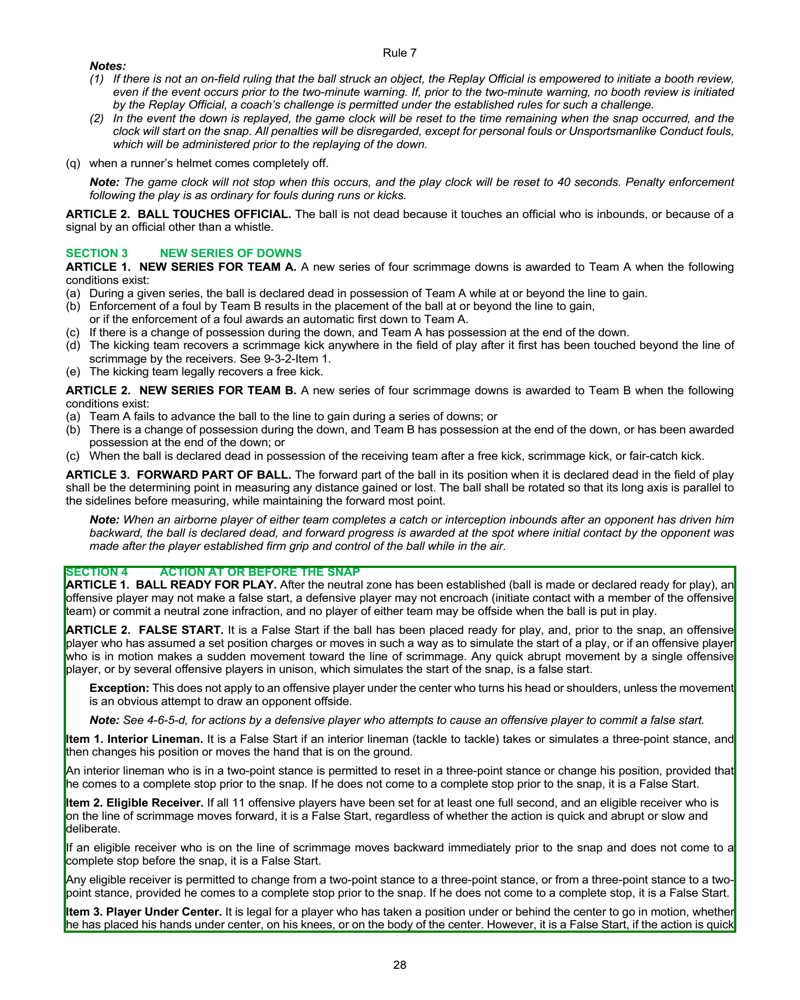

In [38]:
document_bot(question)